In [50]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import qibo
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_nature.second_q.mappers import ParityMapper
from qibo import models, gates, hamiltonians
from qibo.noise import IBMQNoiseModel

In [51]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [52]:
mapper = ParityMapper(num_particles=es_problem.num_particles)

In [53]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-1.05016043 * II
+0.40421466 * IZ
+0.18037525 * XX
-0.40421466 * ZI
-0.01134688 * ZZ


In [54]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

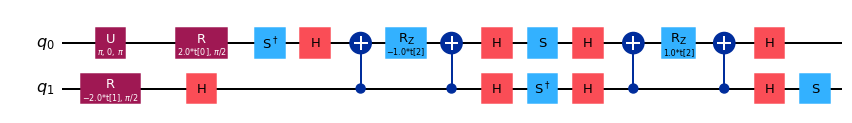

In [55]:
ansatz.decompose(reps=3).draw(output="mpl")

In [56]:
hamil = hamiltonians.Hamiltonian(qubit_op.num_qubits, qubit_op.to_matrix())

In [107]:
def convert(qc):
    qibo_circuit = models.Circuit(qc.num_qubits)
    for instruction, qargs, cargs in qc:
        if instruction.name == 'h':
            qibo_circuit.add(gates.H(qargs[0]._index))
        elif instruction.name == 'x':
            qibo_circuit.add(gates.X(qargs[0]._index))
        elif instruction.name == 'cx':
            qibo_circuit.add(gates.CNOT(qargs[0]._index, qargs[1]._index))
        elif instruction.name == 'ccx':
            qibo_circuit.add(gates.TOFFOLI(qargs[0]._index, qargs[1]._index, qargs[2]._index))
        elif instruction.name == 'rx':
            qibo_circuit.add(gates.RX(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'ry':
            qibo_circuit.add(gates.RY(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'rz':
            qibo_circuit.add(gates.RZ(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'u':
            qibo_circuit.add(gates.U3(qargs[0]._index, theta=instruction.params[0], phi=instruction.params[1], lam=instruction.params[2], trainable=False))
        elif instruction.name == 's':
            qibo_circuit.add(gates.S(qargs[0]._index))
        elif instruction.name == 'sdg':
            qibo_circuit.add(gates.SDG(qargs[0]._index))
        elif instruction.name == 'r':
            qibo_circuit.add(gates.U1(qargs[0]._index, theta=instruction.params[0]))
        elif instruction.name == 'measure':
            # Qibo handles measurements during execution
            pass
        else:
            raise NotImplementedError(f"Gate {instruction.name} is not implemented in this conversion.")
    return qibo_circuit

In [108]:
circuit = convert(ansatz.decompose(reps=3))
# circuit.add(gates.M(*range(2), collapse=False))
circuit.get_parameters()

[(ParameterExpression(2.0*t[0]),),
 (ParameterExpression(-2.0*t[1]),),
 (ParameterExpression(-1.0*t[2]),),
 (ParameterExpression(1.0*t[2]),)]

In [109]:
parameters = {
    "t1": 10e-6,
    "t2": 5e-6,
    "gate_times" : (40*1e-9, 150*1e-9),
    "excited_population" : 0,
    "depolarizing_one_qubit" : 0,
    "depolarizing_two_qubit": 0,
    "readout_one_qubit" : {"0": 0, "1": 0},
}

noise_model = IBMQNoiseModel()
noise_model.from_dict(parameters)
noisy_circuit = noise_model.apply(circuit)

In [111]:
 vqe = models.VQE(noisy_circuit, hamil)
initial_parameters = [0.0] * 4
best, params, extra = vqe.minimize(initial_parameters, method='parallel_L-BFGS-B', compile=False)

RuntimeError: Attempting to perform noisy simulation with `density_matrix=False` and no Measurement gate in the Circuit. If you wish to retrieve the statistics of the outcomes please include measurements in the circuit, otherwise set `density_matrix=True` to recover the final state.

In [98]:
calculated = best + es_problem.hamiltonian.constants['nuclear_repulsion_energy']
actual = es_problem.reference_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", actual)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.9706124170057073
Actual Energy: -1.117343269122583
Percentage Error: -15.12%


In [99]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    hamil = hamiltonians.Hamiltonian(qubit_op.num_qubits, qubit_op.to_matrix())
    vqe = models.VQE(noisy_circuit, hamil)
    initial_parameters = [0.0] * 4
    best, params, extra = vqe.minimize(initial_parameters, method='parallel_L-BFGS-B', compile=False)
    calculated = best + es_problem.hamiltonian.constants['nuclear_repulsion_energy']
    vqe_energies.append(calculated)

Calculating energies: 100%|██████████| 37/37 [00:06<00:00,  5.75it/s]


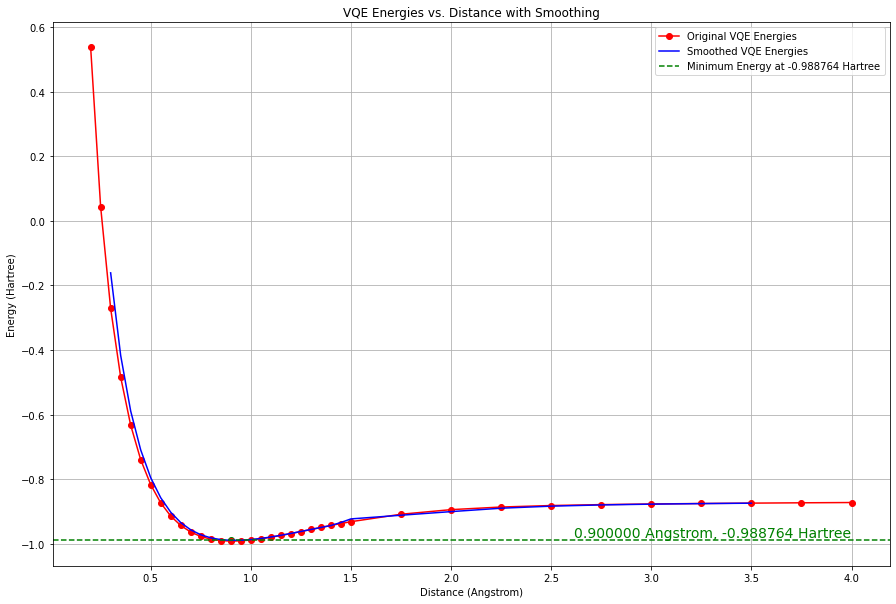

The minimum energy is -0.988764 Hartree at a distance of 0.900000 Angstrom


In [100]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Find the minimum energy and corresponding distance
min_energy = smoothed_energies.min()
min_energy_distance = adjusted_distances[smoothed_energies.argmin()]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')

# Draw a horizontal line at the minimum energy point
plt.axhline(min_energy, color='green', linestyle='--', label=f'Minimum Energy at {min_energy:.6f} Hartree')
plt.scatter(min_energy_distance, min_energy, color='green')  # Mark the minimum point
plt.text(distances[-1], min_energy, f'{min_energy_distance:.6f} Angstrom, {min_energy:.6f} Hartree', color='green', fontsize=14, ha='right', va='bottom')


plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy:.6f} Hartree at a distance of {min_energy_distance:.6f} Angstrom")